# Proyecto Individual IE-0247

### Fabián Muñoz Rojas

### Escuela de Ingeniería Eléctrica

### Introducción

En este proyecto se realizará el análisis de electrocardiogramas (ECG), las cuales son representaciones gráficas de cada período de un ciclo cardíaco. Esta es la técnica más usada en la actualidad para detectar patologías en el corazón y la supervisión de tratamientos que influyan en el funcionamiento de este órgano, Azcona [1]. 
Es fundamental poder analizar estas señales para hacer un correcto diagnóstico de enfermedades cardiovasculares ya que esta es la principal causa de un tercio de las muertes a nivel mundial, como mencionan Kachuee et al [2]. El análisis manual de estas señales da paso muchos errores humanos debido a la dificultad de detectar y categorizar irregularidades en las señales cardíacas. La solución que se ha implementado para este problema es la aplicación de programas que filtren, procesen, analicen, detecten y clasifiquen los electrocardiogramas de una manera sistemática. Este proceso involucra un entrenamiento previo a las máquinas y aprendizaje automático a través de la implementación de una estructuración de las señales para que el programa pueda aprender las especificaciones y detalles que son necesarios para realizar un análisis efectivo. Claramente, en este proceso esta involucrado una manipulación de datos masiva, junto a modelos matemáticos y estadísticos que permitan la creación del programa.


# Etapa 1
Esta etapa tiene como objetivo es automatizar el proceso de la transformación de archivos de audio .wav a representaciones gráficas con el fin de analizar frecuencias cardíacas con todos los elementos que la componen, así como la tensión que emite cada latido, la frecuencia, entre otros elementos. El código implementado es una adaptación del trabajo de del RIo y McKiernan [3]. Se tomaron 15 grabaciones de diferentes corazones de libre acceso de PhysioNet[4]. Además de graficar las 15 señales, se tomo una señal en especifico ("b0001.wav") para recortar el tiempo de grabación y graficar tres latidos como tanto solo un latido. En esta sección del código solo se presentara las partes de este mismo que son necesarias para extraer los valores para la detección de picos R y la obtención de la frecuencia cardíaca. 


### Desarrollo del código

Primeramente, se importan todas las bibliotecas necesarias para el correcto funcionamiento del programa como lo es para graficar las señales y modificar sus propiedades. 

In [1]:
# Imports python libraries
import numpy as np
import random as rd
import wave
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.signal import butter, lfilter, filtfilt #for filtering data
from statistics import stdev
sys.path.insert(1, r'./../functions') # add to pythonpath

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

Se define la función que se utilizara posteriormente para recuperar datos valiosos de la señal como el tiempo, la frecuencia, los valores del voltaje, entre otros. 

In [2]:
#Function that extracts the number of recording channels, sampling rate, time and signal
#variable is the path and filename of the .wav file
def ecg(variable):
    record = wave.open(variable, 'r') # load the data

    # Get the number of channels, sample rate, etc.
    numChannels = record.getnchannels() #number of channels
    numFrames = record.getnframes() #number of frames
    sampleRate = record.getframerate() #sampling rate
    sampleWidth = record.getsampwidth()
    
    # Get wave data
    dstr = record.readframes(numFrames * numChannels)
    waveData = np.frombuffer(dstr, np.int16)

    # Get time window
    timeECG = np.linspace(0, len(waveData)/sampleRate, num=len(waveData))

    return timeECG, waveData

Esta sección del código se encarga de importar las señales que se deseen observar. En el caso de este proyecto se va a utilizar solo una señal (b0001.wav) pero el proceso se repitió para las quince señales utilizadas en el documento anterior

In [3]:
#Test data
nice = ["b0001"]

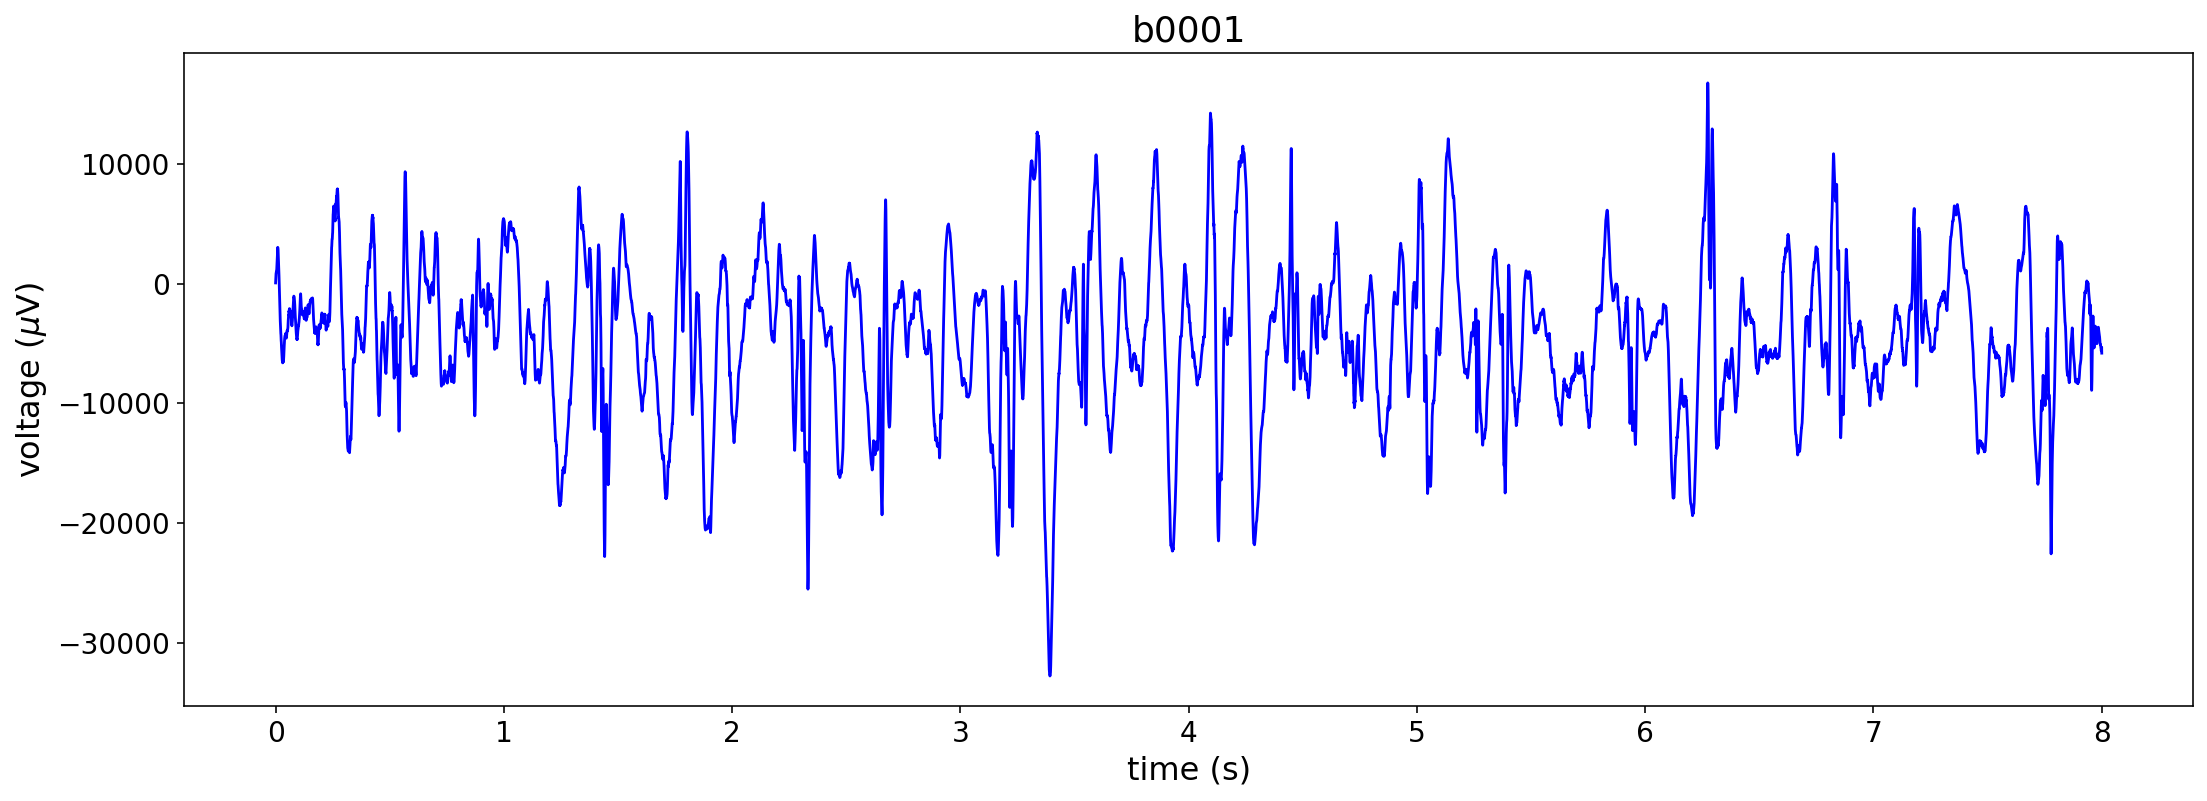

In [4]:
for i in range(0, len(nice)):
    timeECG, waveData = ecg(nice[i]+'.wav')
    # Plotting EMG signal
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'voltage ($\mu$V)')
    plt.plot(timeECG,waveData, 'b')
    plt.title(nice[i])
    plt.show()

Después de graficar la o las señales deseadas se necesita recuperar ciertos datos de esta misma con el fin de utilizar valores necesarios para el análisis posterior que se va a hacer.

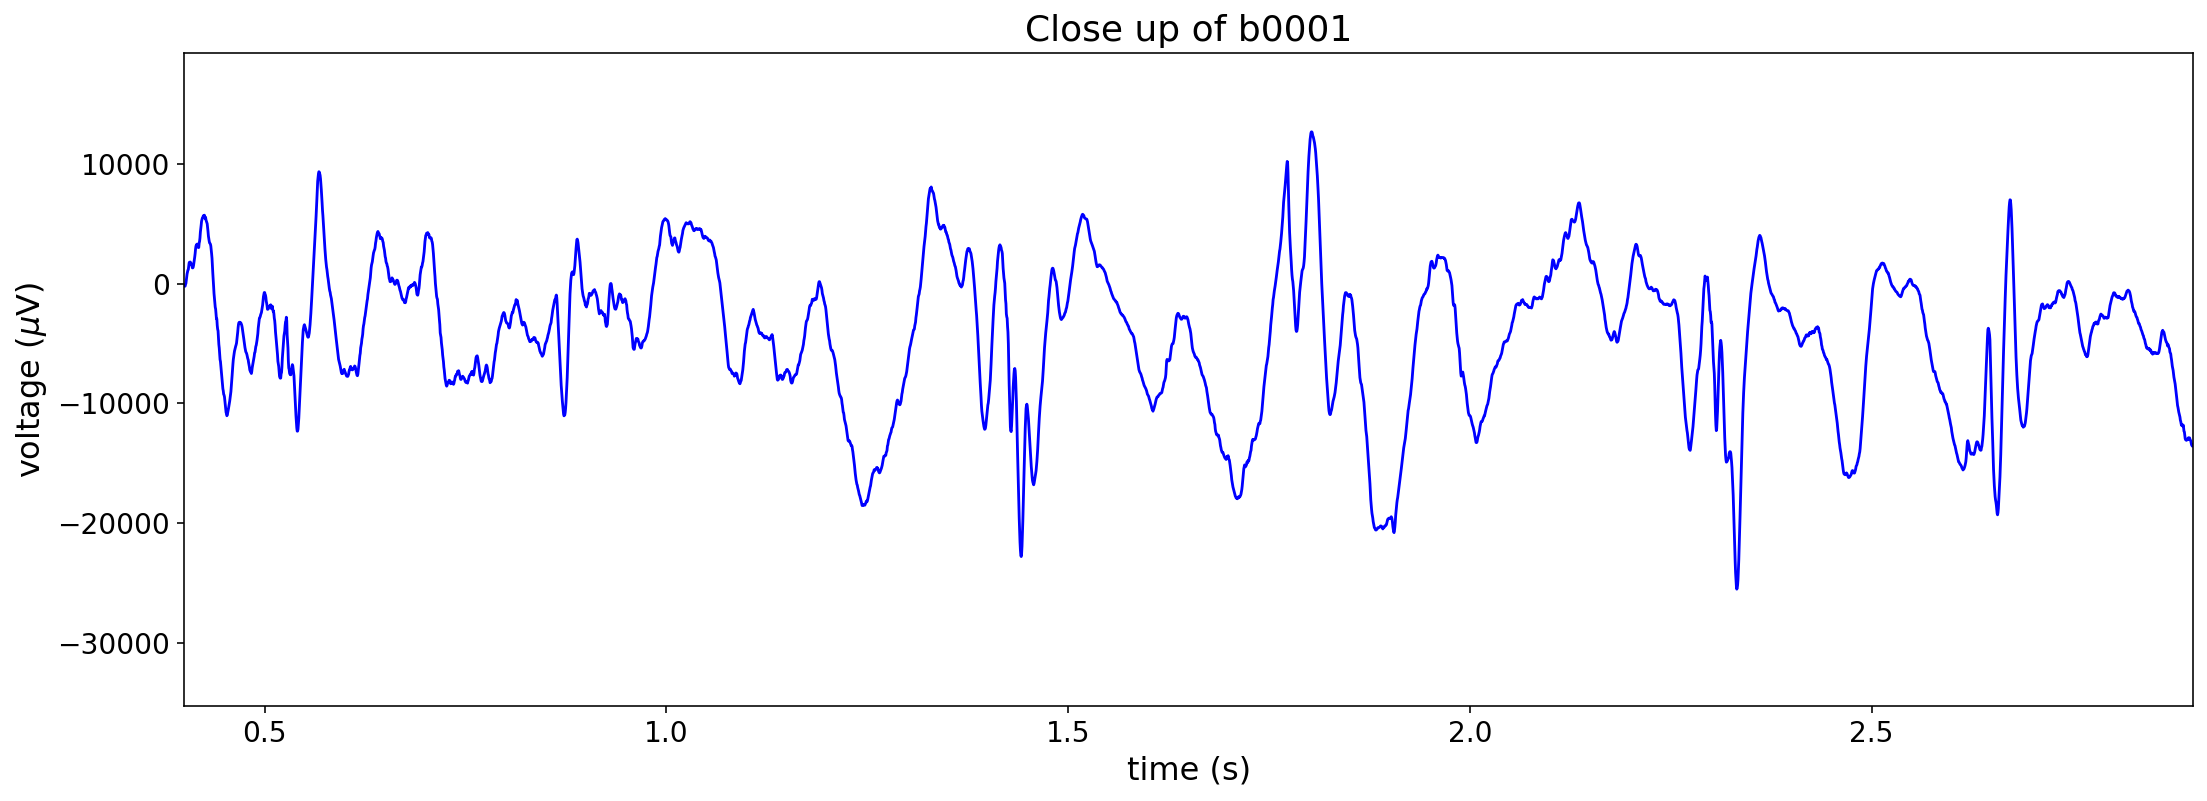

In [5]:
#Obtaining data
timeECG, waveData = ecg("b0001.wav")

# Plotting EMG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG,waveData, 'b')
plt.xlim(.40,2.9)
plt.title("Close up of b0001")
plt.show()

Es necesario ajustar el recorte del tiempo para cada señal que se quisiese analizar. Se ocupa seleccionar un lapso de tiempo donde la señal sea lo más estable posible para no tener irregularidades en la lectura de los picos R. Igualmente, no se pueden despreciar del todo porque estas mismas irregularidades podrían indicar un trastorno cardíaco. 

In [6]:
#Seconds at which we are going to cut the recording
n1 = 0
n2 = 1.55

m1 = int(n1*1)
m2 = int(n2*10000)

print(timeECG[m1])
print(timeECG[m2])

0.0
7.75048440527533


In [7]:
timeECG, waveData = timeECG[m1:m2], waveData[m1:m2]

# Etapa 2

El objetivo de esta segunda es estimar la frecuencia cardíaca de las 15 señales utilizadas en la etapa anterior. El primer elemento para deducir la frecuencia cardíaca es la detección de los picos R. Estos picos constituyen los puntos donde el voltaje de la señal es mayor, señalando cuando ocurre un latido. Se define una función que se encarga de detectar estos máximos y tiene un umbral que se tiene que ir ajustando para cada señal. La idea del umbral es ir ajustando los niveles en lo que se declara un pico R, entre mayor sea el umbral se van a ir filtrando los elementos que no son un pico R y se disminuye el umbral si no se estan detectando todos los picos R. El valor del umbral cambiara para cada función y es un proceso de análisis tras obserrvar el resultado de la señalización de picos R

In [32]:
def detecta_maximos_locales(timeECG, waveData, threshold_ratio=0.6):
    # If not all the R peaks are detected, lower the threshold_ratio
    # If components that are not R peaks (like T waves) are detected, up the threshold_ratio

    if len(timeECG) != len(waveData): #Raises an error if two arrays have different lengths
        raise Exception("The two arrays have different lengths.")
    
    interval = max(waveData) 
    threshold = threshold_ratio*interval 
    maxima = []
    maxima_indices = []
    mxs_indices = []
    banner = False
    
    for i in range(0, len(waveData)):
            
        if waveData[i] >= threshold:#If a threshold value is surpassed,
            # the indices and values are saved 
            banner = True
            maxima_indices.append(i)
            maxima.append(waveData[i])
            
        elif banner == True and waveData[i] < threshold: #If the threshold value is crossed
            # the index of the maximum value in the original array is saved
            index_local_max = maxima.index(max(maxima))
            mxs_indices.append(maxima_indices[index_local_max])
            maxima = []
            maxima_indices = []
            banner = False     

    return mxs_indices

In [33]:
mxs_indices = detecta_maximos_locales(timeECG, waveData)

La siguiente sección grafica y señala los puntos donde un pico R se presentan.

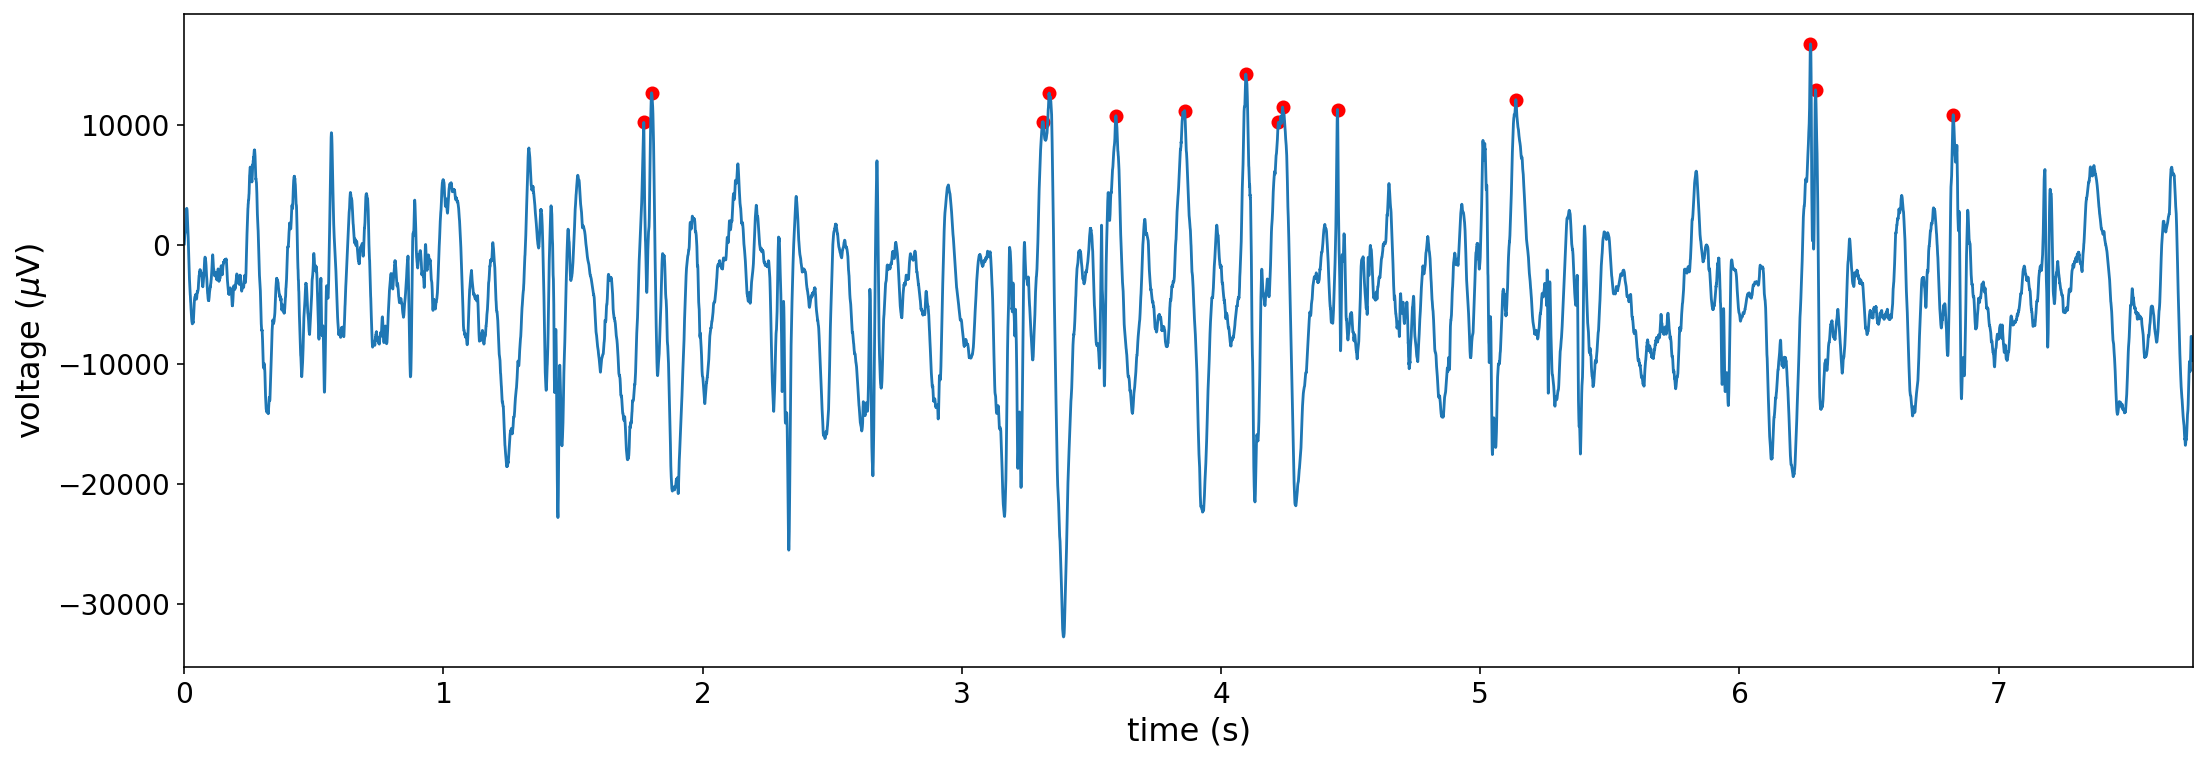

In [34]:
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(min(timeECG),max(timeECG))
plt.plot(timeECG, waveData)
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.show()

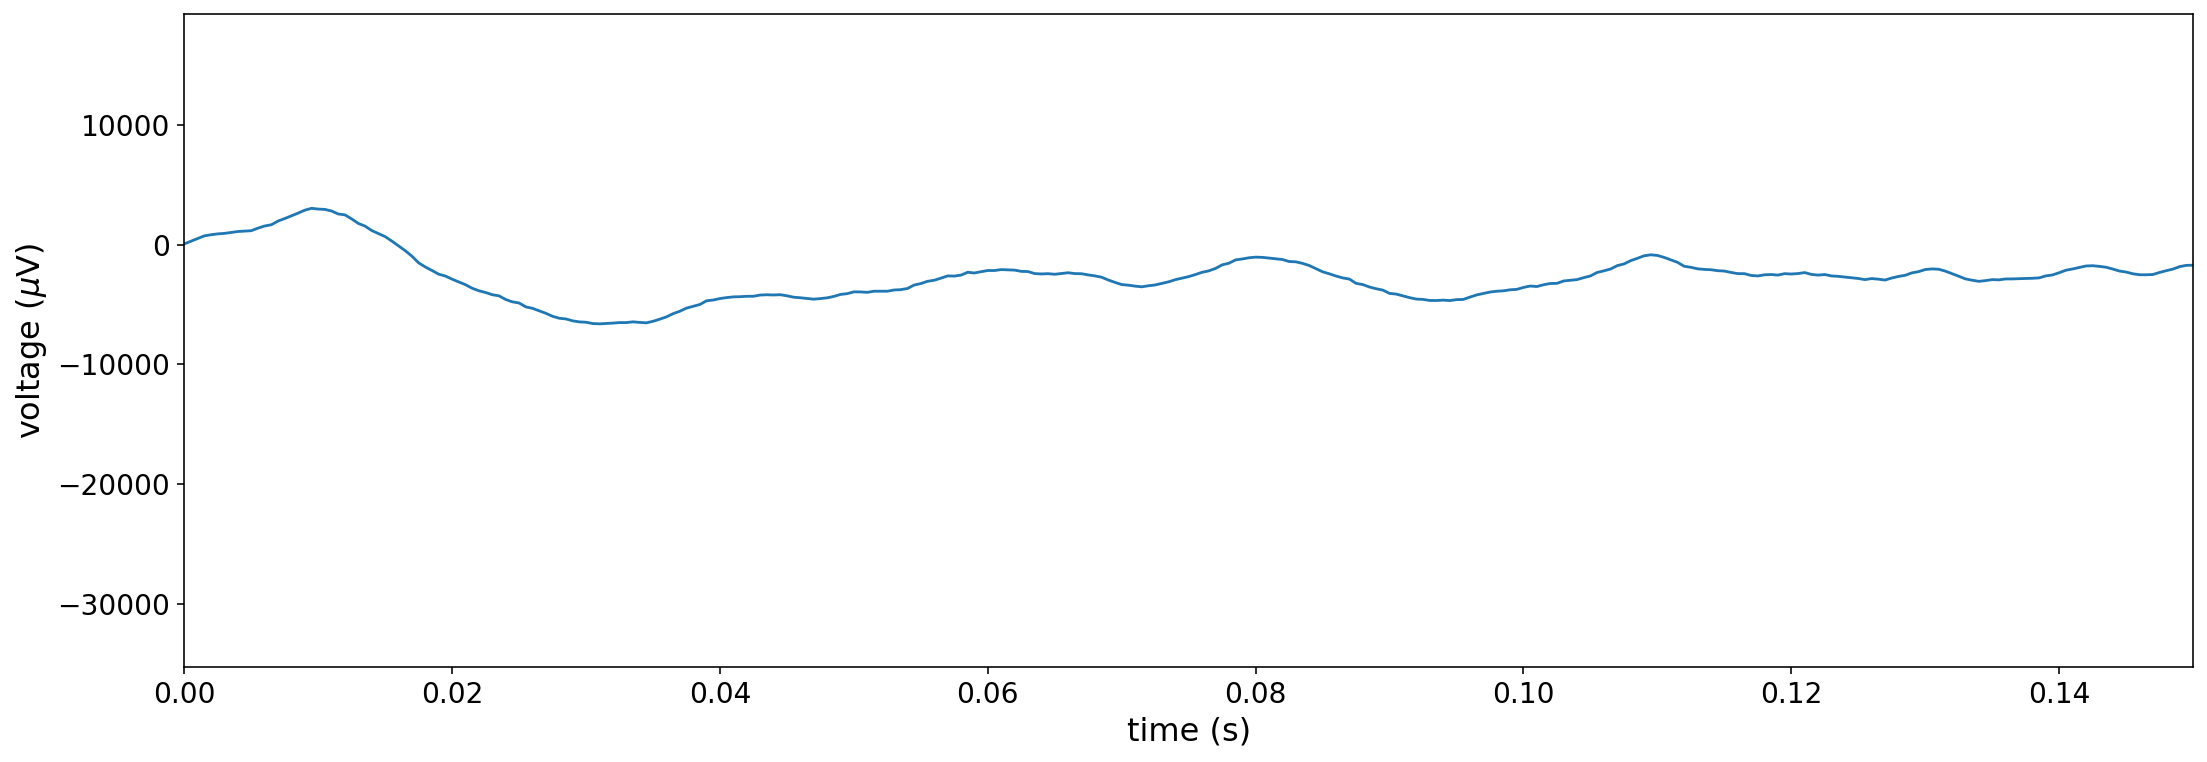

In [35]:
# Close up from an initial second to an end second
init_sec = 0
end_sec = 3
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG[init_sec*100],timeECG[end_sec*100])
plt.plot(timeECG[init_sec*10000:end_sec*10000], waveData[init_sec*10000:end_sec*10000])
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.show()

# Frecuencia cardíaca
Lo que resta del código se encarga de obtener el BPM (latidos por minuto) de la señal y se encarga de graficar la frecuencia cardíaca junto con su promedio y su desviación estandar

In [36]:
mean_bpm = 60*(len(mxs_indices)/(timeECG[-1]-timeECG[0]))
print("Beats per minute:", mean_bpm)

Beats per minute: 108.38731531066522


In [37]:
heart_rate = [(60/(timeECG[mxs_indices[i+1]]-timeECG[mxs_indices[i]])) \
              for i in range(0, len(mxs_indices)-1)]
time = timeECG[mxs_indices]

mean_vec = [mean_bpm for i in range(0, len(time)-1)]
std_vec_plus = [mean_bpm+stdev(heart_rate) for i in range(0, len(time)-1)]
std_vec_minus = [mean_bpm-stdev(heart_rate) for i in range(0, len(time)-1)]

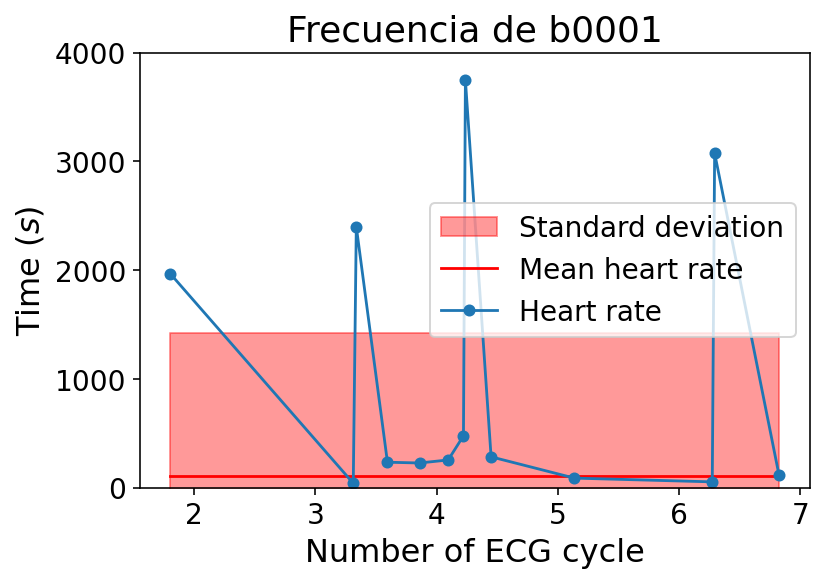

In [38]:
plt.fill_between(time[1:], std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], mean_vec, c="r", label = "Mean heart rate")
plt.plot(time[1:], heart_rate, markersize=5, marker = "o", label="Heart rate")
plt.ylim((0, 4000))
plt.title("Frecuencia de b0001")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend()
plt.show()

# Resultados y análisis
Los resultados obtenidos fueron variados pero se van a mostrar solamente  5 con el fin de poder analizar más profundamente cada una de las frecuencias cardíacas
<img src = "C:\Jupyter folder\ecg\f de b1.png">
En esta primera señal se puede observar que hay muchos picos en los valores de la frecuencia. La grafica representa lo que dura un ciclo para cada ciclo de la señal en términos de tiempo. Lo que quiere decir este gráfico es que la frecuencia de cada latido es muy irregular por lo que podría significar que existen problemas de salud.
<img src = "C:\Jupyter folder\ecg\f de b2.png">
Para esta segunda señal se ve un aumento súbito en el 5to ciclo (a donde se comenzo la medición) pero justamente después se estabiliza, lo que puede indicar que la señal esta siendo interferida por algún ruido, pero se podría decir que tiene una frecuencia saludable.
<img src = "C:\Jupyter folder\ecg\f de b 3.png">
En esta tercera gráfica,se puede observar un comportamiento similar al anterior donde el tiempo de la frecuencia se mantiene relativamente cercano a los 200ms pero en parte del segundo ciclo hay interferencia en la señal.
<img src = "C:\Jupyter folder\ecg\f de b4.png">
Para esta cuarta señal, se tiene un comportamiento similar donde justamente al principio del 5to ciclo se presenta una disrupción y se estabiliza para el comienzo del 6to ciclo, presentando un comportamiento saludable.
<img src = "C:\Jupyter folder\ecg\f de b5.png">
En la ultima señal que se analizara, se presenta un comportamiento irregular como en la primera señal, lo que representa inconsistencias en la frecuencia cardíaca para cada latido lo que podía ser señal de problemas de salud.

Tomando estas cinco señales, se puede enmarcar una manera sistemática de como analizar los gráficos. En el caso de que se mantenga una frecuencia relativamente constante, a pesar de ciertas irrupciones que se presentan (aunque hay que tener en cuenta que también podrian representar un indicio de problemas de salud) son debidas a interferencias en la señal, se podría asumir que se trata de un corazón saludable. En un caso similar a la primera y quinta señal, se puede asumir que existen problemas de saludo por irregularidades en la frecuencia cardíaca.

# Conclusiones
La capacidad realizar estas mediciones tiene un gran impacto y es de suma relevancia para el área de la salud. Permite la pronta detección de posibles indicios de problemas cardíacos, lo que permite un eficaz diágnostico y tratamiento para la persona que sufre de irregularidades en el corazón. Además de esto, precisamente para el objetivo de la investigación, permite desarrollar entendimiento en la interpretación de señales y las posibles transformaciones que se puedan generar sobre estas. Por último, el trabajo conlleva práctica en otras habilidades útiles para un correcto desempeño en el área laboral.  


# References

[1] Azcona, L. (2009). El electrocardiograma en A, López y C, Macaya (Ed.), Libro de la Salud Cardiovascular del Hospital Clínico San Carlos y la Fundación BBVA. (cap, 4). Fundación BBVA 

[2] Kachuee, M., Fazeli, S. y Sarrafzadeh, M. (2018). ECG Heartbeat Classification: A Deep Transferable Representation. https://arxiv.org/pdf/1805.00794.pdf
[Cadogan, 2019] Cadogan, M. (2019). PR Interval. https://litfl.com/pr-interval-ecg-library/ Accessed May 8, 2020.

[3] Del Rio, A y McKiernan, E. (2020). ECGanalysis. [Computer Software]. https://gist.github.com/emckiernan/3e7e86a48256777e9e6a44ede032d938/f3ce7675f99ec90058781b4bb7e9b867e1f51a53

[4] Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... y Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.